__Note from the student:__  
*Lines marked '##' are my own notes. These may include resources I've used, but they're primarily for  pseudo-code and my own thought process so that I can "talk myself through it" when reviewing the code later.*  

**Note to self:**  
*You got this!*

# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
## Display counts of dtypes to identify columns containing strings,
## which produce 'ValueError: could not convert string to float:'
## when later fitting the data to the Standard Scaler function
df.dtypes.value_counts()

float64    76
object     10
dtype: int64

In [6]:
## Can also use 'df.info()' for a more comprehensive breakdown
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   loan_status                 68817 non-null  object 
 8   pymnt_plan                  68817 non-null  object 
 9   dti                         68817 non-null  float64
 10  delinq_2yrs                 68817 non-null  float64
 11  inq_last_6mths              68817 non-null  float64
 12  open_acc                    68817 non-null  float64
 13  pub_rec                     688

In [7]:
## Display columns that include dtype 'object'
df.select_dtypes(include=['object']).columns

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')

## Split the Data into Training and Testing

In [8]:
# Create our features

## This 'for loop' returns columns not labeled 'loan_status', though not useful for this exercise given the number of columns with object dtypes
# x_cols = [i for i in df.columns if i not in ('loan_status')]

## Drop all columns included in the list. Wordy, and columns must be identified ahead of time. Not useful in the event the dataset changes
# X = df.drop(columns=['home_ownership','verification_status','issue_d','loan_status','pymnt_plan','initial_list_status','next_pymnt_d','application_type','hardship_flag','debt_settlement_flag'])

## Locate within the columns data of dtype 'float64'. Significantly shorter and easier, though still a bit confusing to look at
# X = df.loc[:,(df.dtypes=='float64').values]

## The simplest option to me, select_dtypes() with the exclusion of dtype 'object'
X = df.select_dtypes(exclude=['object'])

# Create our target
y = df['loan_status']

In [9]:
X

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,9.60,0.0,0.0,9.0,0.0,2684.0,...,0.0,3.0,80.0,0.0,0.0,0.0,20625.0,6798.0,11300.0,5425.0
68813,12000.0,0.2727,368.37,63000.0,29.07,0.0,0.0,8.0,0.0,13314.0,...,0.0,5.0,96.2,0.0,0.0,0.0,87939.0,60350.0,13500.0,62939.0
68814,5000.0,0.1992,185.62,52000.0,14.86,0.0,0.0,5.0,1.0,3715.0,...,0.0,3.0,100.0,0.0,1.0,0.0,30592.0,18611.0,3600.0,18492.0
68815,40000.0,0.0646,1225.24,520000.0,9.96,0.0,1.0,21.0,0.0,59529.0,...,0.0,3.0,98.2,12.5,0.0,0.0,1033574.0,95958.0,100800.0,78634.0


In [10]:
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [11]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [12]:
y

0        low_risk
1        low_risk
2        low_risk
3        low_risk
4        low_risk
           ...   
68812    low_risk
68813    low_risk
68814    low_risk
68815    low_risk
68816    low_risk
Name: loan_status, Length: 68817, dtype: object

In [13]:
# Check the balance of our target values
print(y.value_counts())

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64


In [14]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape

(51612, 76)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [15]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [16]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
scaler.fit(X_train)

StandardScaler()

In [17]:
# Scale the training and testing data
scaled_X_train = scaler.transform(X_train)
scaled_X_train#[:5]

array([[-1.46833559, -0.82153497, -1.49317685, ..., -0.81999939,
         1.06159632, -0.79918618],
       [-0.7493051 , -1.08086564, -0.69775565, ..., -0.15204545,
        -0.19662017, -0.29882375],
       [-0.65213882, -0.50618887, -0.92691543, ...,  0.30768197,
         1.32589623,  0.48924906],
       ...,
       [ 0.319524  , -0.201216  , -0.133886  , ..., -0.93600831,
        -0.59865384, -0.85807083],
       [-0.49424361,  0.35271432, -0.72156941, ...,  0.31999626,
        -0.26362578,  0.22032289],
       [ 0.319524  , -0.50618887, -0.18477188, ...,  2.43193071,
         1.20305261,  2.81566353]])

In [18]:
scaled_X_test = scaler.transform(X_test)
scaled_X_test#[:5]

array([[-6.52138821e-01,  6.43386073e-02, -4.99758263e-01, ...,
        -5.23950761e-01, -8.51786155e-01,  2.62636931e-03],
       [-6.25418093e-01,  6.99180093e-01, -8.00255341e-01, ...,
        -5.07659627e-01, -8.86666867e-02, -3.76198166e-01],
       [ 2.26284965e+00, -9.50162983e-01,  2.68802733e+00, ...,
         5.25704901e-02, -2.22677910e-01,  7.69780450e-02],
       ...,
       [-1.66307410e-01,  5.80925307e-01, -4.16462096e-01, ...,
        -7.84085634e-01, -8.85288961e-01, -7.99186184e-01],
       [-1.07967046e+00, -3.02873625e-01, -1.03066301e+00, ...,
        -7.95754551e-01, -1.01557765e+00, -7.88901000e-01],
       [ 2.26284965e+00,  3.52714315e-01,  3.10152711e+00, ...,
        -4.85943929e-01, -4.53475018e-01,  5.93126522e-02]])

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [19]:
# Resample the training data with the BalancedRandomForestClassifier
## \11-Classification\3\08-Ins_Do_Precision_Recall_Curve\Solved\pr_curve.ipynb
## \11-Classification\3\09-Stu_Do_Credit_Card_Fraud\Solved\cc_fraud.ipynb
## \11-Classification\2\04-Stu_Predicting_Fraud\Solved\preventing-fraud.ipynb
## \11-Classification\2\05-Ins_Random_Forest\Solved\random-forest.ipynb

from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [20]:
y_pred_brf = brf.predict(X_test)

In [21]:
# Calculated the balanced accuracy score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
acc_score = accuracy_score(y_test, y_pred_brf)

print(f'Accuracy Score: {acc_score}')

Accuracy Score: 0.810462074978204


In [22]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_brf)
cm_df = pd.DataFrame(
    cm, index=['Actual 0','Actual 1'], columns=['Predicted 0','Predicted 1']
)

print('Confusion Matrix')
display(cm_df)

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,59,42
Actual 1,3219,13885


In [23]:
# Print the imbalanced classification report
print('Classification Report')
print(classification_report_imbalanced(y_test, y_pred_brf))

Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.58      0.81      0.03      0.69      0.46       101
   low_risk       1.00      0.81      0.58      0.89      0.69      0.49     17104

avg / total       0.99      0.81      0.59      0.89      0.69      0.48     17205



In [24]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_
importances_sorted = sorted(zip(brf.feature_importances_, X.columns), reverse=True)

importances_sorted

[(0.0655635817623315, 'total_rec_int'),
 (0.06528036081873223, 'last_pymnt_amnt'),
 (0.06277129875620881, 'total_pymnt_inv'),
 (0.05985163433565138, 'total_rec_prncp'),
 (0.055053063169639246, 'total_pymnt'),
 (0.033776751297507714, 'int_rate'),
 (0.019291167552657758, 'out_prncp_inv'),
 (0.018948515278747545, 'dti'),
 (0.018793237773830143, 'mths_since_recent_inq'),
 (0.017864791938440518, 'tot_hi_cred_lim'),
 (0.01672966122818627, 'tot_cur_bal'),
 (0.016283741981875707, 'mo_sin_old_rev_tl_op'),
 (0.015628835766330406, 'mo_sin_old_il_acct'),
 (0.015615076982225373, 'installment'),
 (0.015538223669480012, 'avg_cur_bal'),
 (0.01539585947982506, 'total_il_high_credit_limit'),
 (0.015275588842098637, 'revol_bal'),
 (0.015267976489913135, 'annual_inc'),
 (0.014807550783973009, 'all_util'),
 (0.014797667518775108, 'total_bc_limit'),
 (0.014374850654811805, 'bc_util'),
 (0.014282098039846664, 'il_util'),
 (0.014023783781052492, 'max_bal_bc'),
 (0.01382969609496035, 'total_bal_il'),
 (0.01381

           0                         1
0   0.065564             total_rec_int
1   0.065280           last_pymnt_amnt
2   0.062771           total_pymnt_inv
3   0.059852           total_rec_prncp
4   0.055053               total_pymnt
..       ...                       ...
71  0.000000          num_tl_120dpd_2m
72  0.000000               delinq_amnt
73  0.000000   collection_recovery_fee
74  0.000000  chargeoff_within_12_mths
75  0.000000            acc_now_delinq

[76 rows x 2 columns]
                          Feature Importances
1                                            
acc_now_delinq                       0.000000
tax_liens                            0.000000
recoveries                           0.000000
policy_code                          0.000000
chargeoff_within_12_mths             0.000000
...                                       ...
total_pymnt                          0.055053
total_rec_prncp                      0.059852
total_pymnt_inv                      0.062771
las

<AxesSubplot:title={'center':'Feature Importances'}, ylabel='1'>

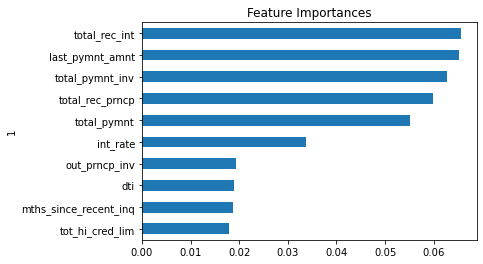

In [25]:
## Visualization of features by importance
importances_df = pd.DataFrame(sorted(zip(brf.feature_importances_, X.columns), reverse=True))
print(importances_df)

importances_sorted = importances_df.set_index(importances_df[1])\
                                   .drop(columns=1)\
                                   .rename(columns={0: 'Feature Importances'})\
                                   .sort_values(by='Feature Importances')

print(importances_sorted)
# importances_sorted = importances_df.sort_values(by='Feature Importances')

importances_sorted.tail(10).plot(kind='barh', title='Feature Importances', legend=False)

### Easy Ensemble Classifier
\#\# [imbalanced-learn: EasyEnsembleClassifier](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.EasyEnsembleClassifier.html#imblearn.ensemble.EasyEnsembleClassifier)  
\#\# [imbalanced-learn: Compare ensemble classifiers using resampling](https://imbalanced-learn.org/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html)

In [26]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier()
eec.fit(X_train, y_train)
y_pred_eec = eec.predict(X_test)

In [27]:
# Calculated the balanced accuracy score
acc_score_eec = balanced_accuracy_score(y_test, y_pred_eec)
print(f'Accuracy Score: {acc_score_eec}')

Accuracy Score: 0.7133482758940066


In [28]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_eec)

array([[   67,    34],
       [ 4048, 13056]], dtype=int64)

In [29]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.66      0.76      0.03      0.71      0.50       101
   low_risk       1.00      0.76      0.66      0.86      0.71      0.51     17104

avg / total       0.99      0.76      0.66      0.86      0.71      0.51     17205



### Final Questions

1. Which model had the best balanced accuracy score?  
   Balanced Random Forest  
<br>
2. Which model had the best recall score?  
   Balanced Random Forest  
<br>
3. Which model had the best geometric mean score?  
   Easy Ensemble Classifier  
<br>
4. What are the top three features?  
   total_rec_int                        0.065564  
   last_pymnt_amnt                      0.065280  
   total_pymnt_inv                      0.062771